## Simpson's Paradox

In [1]:
!pip install dowhy pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.2/399.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.6.7
    Uninstalling cvxpy-1.6.7:
      Successfully uninstalled cvxpy-1.6.7


In [4]:
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt

### 1. Create the Dataset

We’ll reconstruct the dataset from
|               | **Drug**                  | **No Drug**               |
|---------------|---------------------------|----------------------------|
| **Men**       | 81/87 recovered (93%)     | 234/270 recovered (87%)    |
| **Women**     | 192/263 recovered (73%)   | 55/80 recovered (69%)      |
| **Overall**   | 273/350 recovered (78%)   | 289/350 recovered (83%)    |


In [5]:
data = []

# Men - Drug
data += [{"gender": 1, "drug": 1, "recovered": 1}] * 81
data += [{"gender": 1, "drug": 1, "recovered": 0}] * (87-81)

# Men - No Drug
data += [{"gender": 1, "drug": 0, "recovered": 1}] * 234
data += [{"gender": 1, "drug": 0, "recovered": 0}] * (270-234)

# Women - Drug
data += [{"gender": 0, "drug": 1, "recovered": 1}] * 192
data += [{"gender": 0, "drug": 1, "recovered": 0}] * (263-192)

# Women - No Drug
data += [{"gender": 0, "drug": 0, "recovered": 1}] * 55
data += [{"gender": 0, "drug": 0, "recovered": 0}] * (80-55)

df = pd.DataFrame(data)
print(df.head())
print(df.shape)

   gender  drug  recovered
0       1     1          1
1       1     1          1
2       1     1          1
3       1     1          1
4       1     1          1
(700, 3)


This gives us the patient-level dataset (700 rows total).

### 2. Define the Causal Model

We specify the graph structure in the GML graph format to reflect the confounder Gender (Z):

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


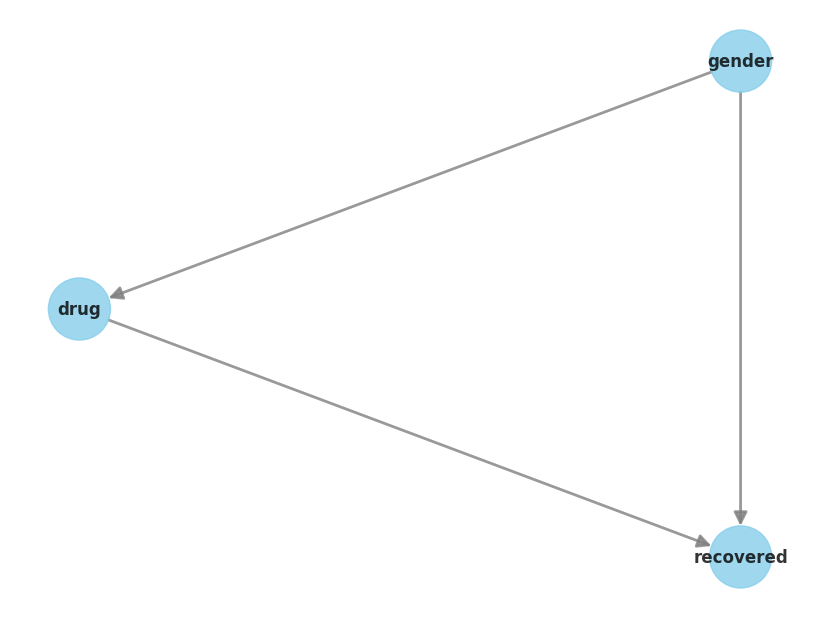

In [6]:
model = CausalModel(
    data=df,
    treatment="drug",
    outcome="recovered",
    common_causes=["gender"],
    graph="digraph {gender -> drug; gender -> recovered; drug -> recovered;}"
)
model.view_model(layout="dot")

The above causal graph shows the assumptions encoded in the causal model. We can now use this graph to first identify the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.

__Remarks__

- You can also use the DOT format.

- To create the causal graph for your dataset, you can use a tool like [DAGitty](https://dagitty.net/dags.html#) that provides a GUI to construct the graph. You can export the graph string that it generates. The graph string is very close to the DOT format: just rename `dag` to `digraph`, remove newlines and add a semicolon after every line, to convert it to the DOT format and input to `DoWhy`.



### 3. Identify the Effect

`DoWhy` philosophy: Keep _identification_ and _estimation_ separate.
Identification can be achieved without access to the data, acccesing only the graph. This results in an expression to be computed. This expression can then be evaluated using the available data in the estimation step. It is important to understand that these are orthogonal steps.

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                        
───────(E[recovered|gender])
d[drug]                     
Estimand assumption 1, Unconfoundedness: If U→{drug} and U→recovered then P(recovered|drug,gender,U) = P(recovered|drug,gender)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
   d                        
───────(E[recovered|gender])
d[drug]                     
Estimand assumption 1, Unconfoundedness: If U→{drug} and U→recovered then P(recovered|drug,gender,U) = P(recovered|drug,gender)



`DoWhy` will use the backdoor adjustment formula automatically.

__Remark__

- Note the parameter flag `proceed_when_unidentifiable`. It needs to be set to `True` to convey the assumption that we are ignoring any unobserved confounding. The default behavior is to prompt the user to double-check that the unobserved confounders can be ignored.

### 4. Estimate the Effect (ACE)

We now estimate the Average Causal Effect using different methods.

In [ ]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting"
)
print("Causal Estimate (ACE):", estimate.value)

Causal Estimate (ACE): 0.05034130891065425


We can also try regression as an alternative:

In [ ]:
estimate_reg = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Regression Estimate (ACE):", estimate_reg.value)

Regression Estimate (ACE): 0.05383557024347052


/home/renku/work/.venv/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


You can input additional parameters to the `estimate_effect` method. For instance, to estimate the effect on any subset of the units, you can specify the `target_units` parameter which can be a string (“ate”, “att”, or “atc”), lambda function that filters rows of the data frame, or a new dataframe on which to compute the effect. You can also specify `effect modifiers` to estimate heterogeneous effects across these variables. See help(CausalModel.estimate_effect).

### 5. Refute the Result (Sensitivity Analysis)

`DoWhy` encourages checking robustness. Let us now look at ways of refuting the estimate obtained. Refutation methods provide tests that every correct estimator should pass. So if an estimator fails the refutation test (p-value is $<0.05$), then it means that there is some problem with the estimator.

Note that we cannot verify that the estimate is correct, but we can reject it if it violates certain expected behavior (this is analogous to scientific theories that can be falsified but not proven true). The below refutation tests are based on either

1.) **Invariant transformations**: changes in the data that should not change the estimate. Any estimator whose result varies significantly between the original data and the modified data fails the test;

- Random Common Cause

- Data Subset

2.) **Nullifying transformations**: after the data change, the causal true estimate is zero. Any estimator whose result varies significantly from zero on the new data fails the test.

- Placebo Treatment

In [ ]:
# Adding a random common cause variable
ref1 = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(ref1)

# Replacing treatment with a random (placebo) variable
ref2 = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(ref2)

Refute: Add a random common cause
Estimated effect:0.05034130891065425
New effect:0.050341308910654234
p value:1.0

Refute: Use a Placebo Treatment
Estimated effect:0.05034130891065425
New effect:0.08562602759700173
p value:0.0



### 6. Plot Recovery Rates (Illustrating Simpson’s Paradox)

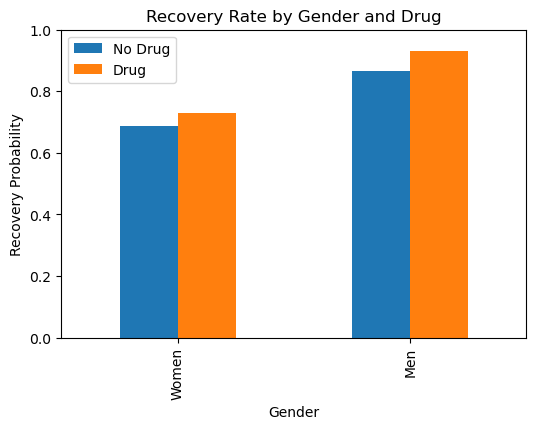

In [ ]:
grouped = df.groupby(["gender", "drug"])["recovered"].mean().unstack()
grouped.index = ["Women", "Men"]

grouped.plot(kind="bar", figsize=(6,4))
plt.title("Recovery Rate by Gender and Drug")
plt.ylabel("Recovery Probability")
plt.xlabel("Gender")
plt.ylim(0,1)
plt.legend(["No Drug", "Drug"])
plt.show()

This shows:

- Drug helps within each gender group.

- Overall average is misleading (Simpson’s paradox)